# matrix factorization on artists (or albums) and supporters

## 1. read in albums_supporters table
## 2. construct similarity matrix (sparse I think!)
## 3. try matrix similarity to return similar artists or albums

In [213]:
import os
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from scipy.sparse import coo_matrix
import scipy
import psycopg2
import tqdm
import numpy as np
from scipy.sparse import linalg
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import implicit
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from timeit import default_timer as timer
%matplotlib inline

## connect to database

In [3]:
#In Python: Define a database name (we're using a dataset on births, so I call it 
# birth_db), and your username for your computer (CHANGE IT BELOW). 
dbname = 'music_db'
username = 'shayneufeld'

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username)

## read in album_supporters table

In [4]:
# query:
sql_query = """
SELECT * FROM album_supporters;
"""
album_supporters = pd.read_sql_query(sql_query,con)

## read in album_info tabl

In [5]:
# query:
sql_query = """
SELECT * FROM album_info;
"""
album_info = pd.read_sql_query(sql_query,con)

## load in sales.csv

In [13]:
sales = pd.read_csv('/Users/shayneufeld/Dropbox/insight/pricecamp/data/sales.csv',index_col=0)

### if artist table is already created, load it here. Otherwise, start making it below:

In [12]:
artist_table = pd.read_csv('/Users/shayneufeld/Dropbox/insight/pricecamp/data/artist_table.csv', index_col=0)
artist_table.head(5)

,artist_id,name,num_albums,num_buyers,num_buys,tags,num_recorded_sales
0,0,(Sandy) Alex G,4,2323,3441,"'alex g', 'pop', 'domino''nsfw', 'pop''pop', '...",35.0
1,1,",,abrightfar,,",1,3,6,"'experimental', 'abrightfar', 'ambient', 'brok...",0.0
2,2,...Of Sinking Ships,1,25,50,"'atmospheric', 'hopesfall', 'indie', 'indie ro...",0.0
3,3,1800HaightStreet,1,166,166,"'chicago house', 'deep techno', 'detroit house...",2.0
4,4,1970's Film Stock,1,5,10,"'1970s', 'experimental', 'broken machine films...",0.0


## create a sparse matrix of artist and supporters. If already made, simply load it in the following cell

In [ ]:
artist_matrix = album_supporters[['artist_name', 'contrib_url']].copy()

artist_matrix['artist_name'] = artist_matrix['artist_name'].astype('category')
artist_matrix['contrib_url'] = artist_matrix['contrib_url'].astype('category')
artist_matrix['buys'] = 1

buys = coo_matrix((artist_matrix['buys'].astype(float),
                  (artist_matrix['artist_name'].cat.codes,
                  artist_matrix['contrib_url'].cat.codes)))

artist_key = dict(enumerate(artist_matrix.artist_name.cat.categories))

# try saving matrix
scipy.sparse.save_npz('/Users/shayneufeld/Dropbox/insight/pricecamp/data/supporters_sparse_matrix.npz', buys)

In [27]:
#load sparse matrix
buys = scipy.sparse.load_npz('/Users/shayneufeld/Dropbox/insight/pricecamp/data/supporters_sparse_matrix.npz')

# create an artist_table

In [165]:
# create a table for each artist, containing number of albums & tags
artist_table = pd.DataFrame()

for i,key in tqdm.tqdm(enumerate(artist_key)):
    artist = artist_key[key]
    artist_info = album_info[album_info.artist_name == artist]
    artist_supp = album_supporters[album_supporters.artist_name == artist]
    
    total_supp = artist_supp.shape[0]
    unique_supp = artist_supp.contrib_url.unique().shape[0]
    num_albums = artist_supp.album_name.unique().shape[0]
    
    artist_sales = sales[sales.artist_name==name]
    num_sales = artist_sales.shape[0]
    
    artist_tags = str()
    for album_tags in artist_info.tags.values:
        artist_tags = artist_tags + str(album_tags[1:-1])
    
    d = {'name':artist,'tags':artist_tags,
         'num_albums':num_albums,'num_buys':total_supp,
        'num_buyers':unique_supp,'artist_id':key,'num_recorded_sales':num_sales}
    
    artist_table = artist_table.append(pd.DataFrame(data=d,index=[i]))

1657it [06:48,  3.89it/s]


In [14]:
artist_table.head(5)

,artist_id,name,num_albums,num_buyers,num_buys,tags,num_recorded_sales
0,0,(Sandy) Alex G,4,2323,3441,"'alex g', 'pop', 'domino''nsfw', 'pop''pop', '...",35.0
1,1,",,abrightfar,,",1,3,6,"'experimental', 'abrightfar', 'ambient', 'brok...",0.0
2,2,...Of Sinking Ships,1,25,50,"'atmospheric', 'hopesfall', 'indie', 'indie ro...",0.0
3,3,1800HaightStreet,1,166,166,"'chicago house', 'deep techno', 'detroit house...",2.0
4,4,1970's Film Stock,1,5,10,"'1970s', 'experimental', 'broken machine films...",0.0


In [24]:
def bm25_weight(X, K1=100, B=0.8):
    """ Weighs each row of a sparse matrix X  by BM25 weighting """
    # calculate idf per term (user)
    X = coo_matrix(X)

    N = float(X.shape[0])
    idf = np.log(N / (1 + np.bincount(X.col)))

    # calculate length_norm per document (artist)
    row_sums = np.ravel(X.sum(axis=1))
    average_length = row_sums.mean()
    length_norm = (1.0 - B) + B * row_sums / average_length

    # weight matrix rows by bm25
    X.data = X.data * (K1 + 1.0) / (K1 * length_norm[X.row] + X.data) * idf[X.col]
    return X

## Implicit Alternating Least Squares

In [25]:
# initialize a model
als = implicit.als.AlternatingLeastSquares(factors=50)

In [28]:
# train the model on a sparse matrix of item/user/confidence weights
start = timer()
als.fit(buys)
end = timer()
print('Time to fit als model: %.0f s' % (end-start))

Time to fit als model: 13 s


In [588]:
als.item_factors.shape

(1657, 50)

In [589]:
buys.shape

(1657, 242214)

In [593]:
artist_id = 0
als_result = als.similar_items(artist_id,N=50)

results = als_result
als_ = pd.DataFrame()

for als_r in results:
    als_ = als_.append(artist_table[artist_table.artist_id==als_r[0]])
    
#print('Artist: %s' % artist_key[artist_id])
#print('Related artists: %s' % related_artists)

In [594]:
related_artists = als_.name.values
related_sales_als = pd.DataFrame()

for als_artist in related_artists:
    related_sales_als_ = sales[sales.artist_name==als_artist].copy()
    related_sales_als = related_sales_als.append(related_sales_als_)

In [595]:
print('Num related sales (als): %.0f' % related_sales_als.shape[0])

Num related sales (als): 1694


In [596]:
price_analysis = pd.DataFrame(data=np.zeros((3,4)),index=['Price','Revenue','Frac_Revenue'],columns=['a','b','t','p'])
price_analysis

,a,b,t,p
Price,0.0,0.0,0.0,0.0
Revenue,0.0,0.0,0.0,0.0
Frac_Revenue,0.0,0.0,0.0,0.0


In [600]:
item_types

array(['a', 'p', 't', 'b'], dtype=object)

In [601]:
item_labels = ['digital album','physical album','single track download','bundle']

(0, 55)

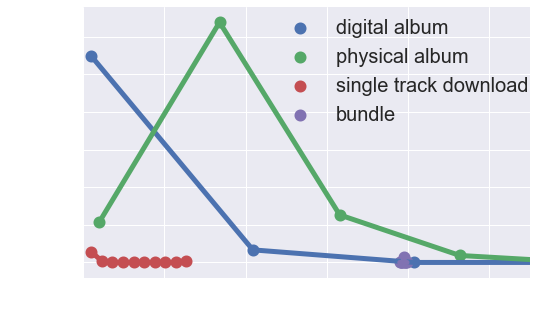

In [614]:
related_sales = related_sales_als
item_types = related_sales.item_type.unique()
best_price = {}
revs = {}
price_analysis = pd.DataFrame(data=None,index=['Price','Revenue','Frac_Revenue'],columns=['a','b','t','p'])
plt.figure(figsize=(8,5))
fontsize=20
for i,item_type in enumerate(item_types):
    test=related_sales[related_sales.item_type==item_type]
    x = np.histogram(test.amount_paid_usd.values)[1][:-1]
    y = np.histogram(test.amount_paid_usd.values)[0]*x
    
    opt = x[np.where(y==y.max())]
    rev = y.max()
    best_price[item_type] = np.round(opt[0])
    revs[item_type] = rev
    price_analysis.loc['Price',item_type] = np.round(opt[0])
    price_analysis.loc['Revenue',item_type] = rev
    
    plt.plot(x,y,linewidth=5)
    plt.scatter(x,y,label=item_labels[i],linewidth=5)
plt.legend(bbox_to_anchor=(0.4,0.5),fontsize=fontsize)
plt.xticks(fontsize=fontsize,color='white')
plt.yticks(fontsize=fontsize,color='white')
plt.xlabel('item price ($)',fontsize=fontsize,color='white')
plt.ylabel('revenue ($)', fontsize=fontsize,color='white')
plt.xlim(0,55)

In [441]:
price_analysis

,a,b,t,p
Price,4,9,2,7
Revenue,21.95,51.24,1.9,116.88
Frac_Revenue,NaN,NaN,NaN,NaN


In [454]:
price_analysis.loc['Frac_Revenue',:] = price_analysis.loc['Revenue',:].values / price_analysis.loc['Revenue',:].values.sum(axis=0)
price_analysis

,a,b,t,p
Price,4,9,2,7
Revenue,21.95,51.24,1.9,116.88
Frac_Revenue,0.114341,0.266917,0.00989738,0.608845


In [469]:
rec['Frac_Revenue'] = np.round(rec.Frac_Revenue.values / rec.Frac_Revenue.values.sum(),2)

In [488]:
rec.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Frac_Revenue</th>\n      <th>Price</th>\n      <th>Revenue</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>b</th>\n      <td>0.3</td>\n      <td>9.0</td>\n      <td>51.24</td>\n    </tr>\n    <tr>\n      <th>p</th>\n      <td>0.7</td>\n      <td>7.0</td>\n      <td>116.88</td>\n    </tr>\n  </tbody>\n</table>'

In [490]:
artist_table

,artist_id,name,num_albums,num_buyers,num_buys,tags,num_recorded_sales,num_recorded_sales_by_related
0,0,(Sandy) Alex G,4,2323,3441,"'alex g', 'pop', 'domino''nsfw', 'pop''pop', '...",35.0,1694
1,1,",,abrightfar,,",1,3,6,"'experimental', 'abrightfar', 'ambient', 'brok...",0.0,100
2,2,...Of Sinking Ships,1,25,50,"'atmospheric', 'hopesfall', 'indie', 'indie ro...",0.0,170
3,3,1800HaightStreet,1,166,166,"'chicago house', 'deep techno', 'detroit house...",2.0,259
4,4,1970's Film Stock,1,5,10,"'1970s', 'experimental', 'broken machine films...",0.0,10
5,5,28,1,1,2,"'electronic', 'psy trance', 'chillout', 'downt...",0.0,75
6,6,2814,2,2641,5474,"'electronic', 'ambient', 'cyberpunk', 'downtem...",45.0,325
7,7,3 Ninjasks,1,29,29,"'3ds', 'electronic', 'ambient', 'chillwave', '...",0.0,50
8,8,36 Questions,2,23,39,"'soundtrack', 'anti-folk', 'contemporary', 'mu...",45.0,232
9,9,5ive,2,1,4,"'5ive', 'boston', 'pelican', 'punk', 'hardcore...",4.0,68


In [485]:
num_sales = 1000
revenue = 0
for item in rec.iterrows():
    num_sales = item[1].Frac_Revenue*num_sales
    revenue += num_sales*item[1].Price

In [486]:
revenue

4170.0

In [279]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.8)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [281]:
linreg = linear_model.LinearRegression(normalize=True)

linreg.fit(x_train,y_train)
linreg.score(x_test,y_test)

0.018450576394634433

That is very bad. Let's try a decision tree before I start doing any feature engineering

In [280]:
tree = DecisionTreeRegressor()
tree.fit(x_train,y_train)
tree.score(x_test,y_test)

0.28173373756668885

In [499]:
rec = pd.DataFrame()
for col in price_analysis.columns.values:
    if price_analysis.loc['Frac_Revenue',col] > 0.2:
        if col == 'a':
            items = 'digital album'
        elif col == 'p':
            item = 'physical'
        elif col == 'b':
            item = 'bundle'
        elif col == 't':
            item = 'track'
        
        
        
        rec = rec.append(price_analysis[col])

In [519]:
rec

,Frac_Revenue,Price,Revenue
b,0.266917,9.0,51.24
p,0.608845,7.0,116.88


In [518]:
pd.DataFrame(data=price_analysis[col])

,p
Price,7
Revenue,116.88
Frac_Revenue,0.608845


In [512]:
price_analysis[col]

Price                  7
Revenue           116.88
Frac_Revenue    0.608845
Name: p, dtype: object

In [495]:
num_sales = 'med'
rec_items = rec.copy()
lower_bound,upp_bound = 0,0
    
if num_sales == 'low':
    lower = 0
    higher = 100

elif num_sales == 'med':
    lower = 100
    higher = 500

elif num_sales == 'hi':
    lower = 500
    higher = 0


for item in rec_items.iterrows():
    lower_bound += lower*item[1].Price
    upper_bound += higher*item[1].Price

if num_sales == 'low':
    revenue = '$<' + str(upper_bound)
elif num_sales == 'med':
    revenue = '$ ' + str(lower_bound) + '-' + str(upper_bound)
elif num_sames == 'hi':
    revenue = '$>' + str(lower_bound)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [497]:
num_sales

'med'

In [496]:
item[1].Frac_Revenue

0.26691670573527115

In [430]:
rev_sum = 0
frac_rev = {}
for key in revs:
    rev_sum += revs[key]
for key in best_price:
    frac = revs[key]/rev_sum
    if frac > .20:
        frac_rev[key] = frac

In [431]:
frac_rev

{'b': 0.26691670573527121, 'p': 0.60884513205188306}

## determine number of artists who have related sales >= 400

In [397]:
num_related_sales = []
for key in tqdm.tqdm(artist_table.artist_id):
    als_result = als.similar_items(key,N=50)

    results = als_result
    als_ = pd.DataFrame()

    for als_r in results:
        als_ = als_.append(artist_table[artist_table.artist_id==als_r[0]])
        
    related_artists = als_.name.values
    related_sales_als = pd.DataFrame()

    for als_artist in related_artists:
        related_sales_als_ = sales[sales.artist_name==als_artist].copy()
        related_sales_als = related_sales_als.append(related_sales_als_)
        
    num_related_sales.append(related_sales_als.shape[0])

100%|██████████| 1657/1657 [34:02<00:00,  1.06s/it]


In [404]:
np.sum(np.asarray(num_related_sales)>200)

853

In [406]:
artist_table['num_recorded_sales_by_related'] = num_related_sales

In [408]:
artist_table.to_csv('/Users/shayneufeld/Dropbox/insight/pricecamp/data/artist_table.csv')

In [427]:
artist_table.head(5)

,artist_id,name,num_albums,num_buyers,num_buys,tags,num_recorded_sales,num_recorded_sales_by_related
0,0,(Sandy) Alex G,4,2323,3441,"'alex g', 'pop', 'domino''nsfw', 'pop''pop', '...",35.0,1694
1,1,",,abrightfar,,",1,3,6,"'experimental', 'abrightfar', 'ambient', 'brok...",0.0,100
2,2,...Of Sinking Ships,1,25,50,"'atmospheric', 'hopesfall', 'indie', 'indie ro...",0.0,170
3,3,1800HaightStreet,1,166,166,"'chicago house', 'deep techno', 'detroit house...",2.0,259
4,4,1970's Film Stock,1,5,10,"'1970s', 'experimental', 'broken machine films...",0.0,10


# model to predict number of buyers given prices

In [63]:
album_feat.head(5)

,index,Bundle,Vinyl,CD,Tape,Digital,Unclassified,album_name,artist_name,location,tags,year
0,0,None,None,None,None,$1,None,"""Condos""-LiveatTheBellHouse",Welcome to Night Vale,New York,['podcasts'],2014.0
1,1,(,None,None,None,70.4,None,"""Emerson""UnreleasedDemo",Wintergatan,Gothenburg,['pop'],2017.0
2,2,$60.30,None,None,None,$13,None,"""ILLESTRUSSIA""",PLAYA x TIGHT EYEZ x MMP,Ukraine,"['300', 'hip-hop/rap', 'instrumental hip-hop',...",2016.0
3,3,None,None,None,None,$1,None,"""TheDebate""-LiveatRoulette",Welcome to Night Vale,New York,"['podcasts', 'night vale']",2014.0
4,4,None,None,None,None,$5,None,"""TheInvestigators""Live",Welcome to Night Vale,New York,"['podcasts', 'cecil baldwin', 'comedy', 'night...",2016.0


In [85]:
album_feat = album_info.copy()
for col in album_feat:
    album_feat.loc[album_feat[col].isnull(),col] = 0

In [75]:
#get number of buyers for each albums
for album in tqdm.tqdm(album_feat.album_name.values):
    num_buyers = album_supporters[album_supporters.album_name == album].shape[0]
    album_feat.loc[album_feat.album_name == album,'num_buyers'] = num_buyers

100%|██████████| 5477/5477 [17:43<00:00,  4.76it/s]


In [87]:
album_feat['num_buyers'] = num_buyers

In [88]:
album_feat.head(5)

,index,Bundle,Vinyl,CD,Tape,Digital,Unclassified,album_name,artist_name,location,tags,year,num_buyers
0,0,0,0,0,0,$1,0,"""Condos""-LiveatTheBellHouse",Welcome to Night Vale,New York,['podcasts'],2014.0,13326.0
1,1,(,0,0,0,70.4,0,"""Emerson""UnreleasedDemo",Wintergatan,Gothenburg,['pop'],2017.0,988.0
2,2,$60.30,0,0,0,$13,0,"""ILLESTRUSSIA""",PLAYA x TIGHT EYEZ x MMP,Ukraine,"['300', 'hip-hop/rap', 'instrumental hip-hop',...",2016.0,140.0
3,3,0,0,0,0,$1,0,"""TheDebate""-LiveatRoulette",Welcome to Night Vale,New York,"['podcasts', 'night vale']",2014.0,1803.0
4,4,0,0,0,0,$5,0,"""TheInvestigators""Live",Welcome to Night Vale,New York,"['podcasts', 'cecil baldwin', 'comedy', 'night...",2016.0,9981.0


In [94]:
album_feat2 = album_feat.copy()
for col in ['Bundle','Vinyl','CD','Tape','Digital','Unclassified']:
    items = album_feat[col].values
    prices = []
    for item in items:
        if not item == 0:
            if ((item[0] == '$') or (item[0] == '£') or (item[0] == '€')):
                price = float(item[1:])

            else:
                try:
                    price = (float(item))
                except:
                    price = None
        else:
            price = 0
        
        prices.append(price)
        
    album_feat2.loc[:,col] = prices

In [95]:
album_feat2.head(10)

,index,Bundle,Vinyl,CD,Tape,Digital,Unclassified,album_name,artist_name,location,tags,year,num_buyers
0,0,0.0,0.0,0.0,0.0,1.0,0.0,"""Condos""-LiveatTheBellHouse",Welcome to Night Vale,New York,['podcasts'],2014.0,13326.0
1,1,NaN,0.0,0.0,0.0,70.4,0.0,"""Emerson""UnreleasedDemo",Wintergatan,Gothenburg,['pop'],2017.0,988.0
2,2,60.3,0.0,0.0,0.0,13.0,0.0,"""ILLESTRUSSIA""",PLAYA x TIGHT EYEZ x MMP,Ukraine,"['300', 'hip-hop/rap', 'instrumental hip-hop',...",2016.0,140.0
3,3,0.0,0.0,0.0,0.0,1.0,0.0,"""TheDebate""-LiveatRoulette",Welcome to Night Vale,New York,"['podcasts', 'night vale']",2014.0,1803.0
4,4,0.0,0.0,0.0,0.0,5.0,0.0,"""TheInvestigators""Live",Welcome to Night Vale,New York,"['podcasts', 'cecil baldwin', 'comedy', 'night...",2016.0,9981.0
5,5,0.0,0.0,0.0,0.0,1.0,0.0,"""TheLibrarian""-LiveatSkirball",Welcome to Night Vale,New York,"['night vale', 'podcasts', 'welcome to night v...",2015.0,2955.0
6,6,0.0,0.0,0.0,0.0,7.0,0.0,"""Thisiswhatyoulearned.""",People Like You,Boston,"['alternative', 'broken world media', 'drum & ...",2014.0,145.0
7,7,0.0,0.0,0.0,0.0,0.0,0.0,#BASEDSHARK,Mayhem,Hamilton,['electronic'],2011.0,2157.0
8,8,0.0,0.0,0.0,0.0,10.0,NaN,"#extrasinamovie|1.20.16|Raleigh,NC|TheRitz",Papadosio,Asheville,"['rock', 'alternative', 'electronic', 'improv'...",2016.0,878.0
9,9,0.0,0.0,0.0,0.0,10.0,NaN,"#extrasinamovie|1.21.16|Nashville,TN",Papadosio,Asheville,"['rock', 'alternative', 'electronic', 'improv'...",2016.0,880.0


In [119]:
album_feat3 = pd.DataFrame()
for row in tqdm.tqdm(album_feat2.iterrows()):
    if row[1][['Bundle','Vinyl','Digital','Tape','CD']].sum() > 0:
        album_feat3 = album_feat3.append(row[1])

5477it [00:29, 188.72it/s]


In [120]:
album_feat3.shape

(4675, 13)

In [124]:
album_feat3 = album_feat3.fillna(value=0)

In [386]:
x = album_feat3[['Bundle','Vinyl','Digital','Tape','CD']].values
y = album_feat3['num_buyers'].values

In [279]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.8)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [281]:
linreg = linear_model.LinearRegression(normalize=True)

linreg.fit(x_train,y_train)
linreg.score(x_test,y_test)

0.018450576394634433

That is very bad. Let's try a decision tree before I start doing any feature engineering

In [280]:
tree = DecisionTreeRegressor()
tree.fit(x_train,y_train)
tree.score(x_test,y_test)

0.28173373756668885

already a considerable improvement. but it's also pretty sensitive to the specific training/testing set (from just manually trying it a few different times). 

a couple different ways forward:

1. add in the tags as features. probably reduce dimensions using PCAs.
    - then you would use the optimal prices as input features and determine the predicted number of buys
    - downside: it could be that the tags dominate the feature importance, and the optimal prices don't make much of a difference? but if that's true ... it's true ... 
    
2. get all the tags. do PCA. do clustering on the PCs. look for ~10 clusters or something. now fit separate prediction models for each cluster.

Okay - plan:

1. get all the tags. one hot encode them. PCA --> reduce dimensions. use to predict # sold. see how it does

In [214]:
def get_tags_from_str(tag_str):
    tag_str = tag_str.replace('[','')
    tag_str = tag_str.replace(']','')
    tag_str = tag_str.replace("'",'')
    tag_str = tag_str.replace(" ",'')
    tags = tag_str.split(sep=',')
    return tags

In [206]:
tags = []
for row in tqdm.tqdm(album_feat3.iterrows()):
    tag_str = row[1].tags
    tag_str = tag_str.replace('[','')
    tag_str = tag_str.replace(']','')
    tag_str = tag_str.replace("'",'')
    tag_str = tag_str.replace(" ",'')
    for tag in tag_str.split(sep=','):
        tags.append(tag)

4675it [00:00, 6463.77it/s]


In [215]:
tags = np.unique(tags)
tag_df = pd.DataFrame(data=None,columns=tags)

for i,row in tqdm.tqdm(enumerate(album_feat3.iterrows())):
    row_tags = get_tags_from_str(row[1].tags)
    tag_df.loc[i,row_tags] = 1

4675it [27:26,  1.37it/s]


In [224]:
tag_df = tag_df.fillna(value=0)

In [240]:
tag_matrix = tag_df.values
pca_tags = PCA(n_components=100)
pca_tags.fit(tag_matrix)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

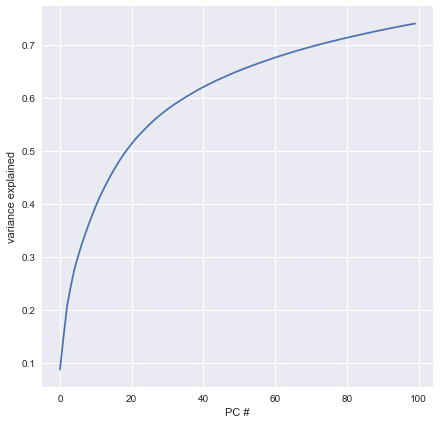

In [241]:
plt.figure(figsize=(7,7))
plt.plot(pca_tags.explained_variance_ratio_.cumsum())
plt.xlabel('PC #')
plt.ylabel('variance explained')

In [243]:
tags_reduced = pca_tags.transform(tag_matrix)

In [287]:
prices_genres = np.append(x,tags_reduced,axis=1)

In [298]:
#split into training and testing
n_trials = prices_genres.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.8)

x_train = prices_genres[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = prices_genres[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [299]:
linreg = linear_model.LinearRegression(normalize=True)

linreg.fit(x_train,y_train)
linreg.score(x_test,y_test)

0.16613121711845824

That is very bad. Let's try a decision tree before I start doing any feature engineering

In [292]:
tree = DecisionTreeRegressor()
tree.fit(x_train,y_train)
tree.score(x_test,y_test)

-0.87663527865016189

In [305]:
album_feat3.to_csv('/Users/shayneufeld/Dropbox/insight/pricecamp/data/album_features.csv')

(0, 1)

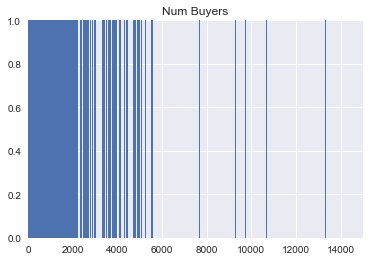

In [322]:
plt.hist(album_feat3.num_buyers.values,bins=400)
plt.title('Num Buyers')
plt.xlim(0,15000)
plt.ylim(0,1)

In [315]:
np.sum(album_feat3.num_buyers.values > 100) / album_feat3.num_buyers.values.shape[0]

0.47679144385026739

In [357]:
np.asarray(y_class)

array(['low', 'low', 'low', ..., 'low', 'low', 'low'],
      dtype='<U3')

In [363]:
y_class = ['low']*y.shape[0]
y_class = np.asarray(y_class)
y_class[album_feat3.num_buyers.values > 100] = 'med'
y_class[album_feat3.num_buyers.values > 500] = 'hi'

In [325]:
from sklearn.ensemble import RandomForestClassifier

In [392]:
#split into training and testing
x = prices_genres

In [426]:
np.savetxt('/Users/shayneufeld/Dropbox/insight/pricecamp/data/prices_genres_features.csv',prices_genres)

In [546]:
y = y_class
x = prices_genres
n_trials = prices_genres.shape[0]
overall,low,med,hi = np.zeros(100),np.zeros(100),np.zeros(100),np.zeros(100)

for i in tqdm.tqdm(range(100)):
    shuf_inds = np.random.permutation(n_trials)
    split_ind = int(n_trials*0.8)

    x_train = x[shuf_inds[:split_ind],:]
    y_train = y[shuf_inds[:split_ind]]

    x_test = x[shuf_inds[split_ind:],:]
    y_test = y[shuf_inds[split_ind:]]


    forest = RandomForestClassifier()
    forest.fit(x_train,y_train)
    
    y_predict = forest.predict(x_test)
    
    overall[i] = forest.score(x_test,y_test)
    med[i] = np.mean(y_predict[y_test=='med'] == 'med')
    hi[i] = np.mean(y_predict[y_test=='hi'] == 'hi')
    low[i] = np.mean(y_predict[y_test=='low'] == 'low')

100%|██████████| 100/100 [00:16<00:00,  6.41it/s]


In [549]:
scores_df = pd.DataFrame(data={'score':low,'class':'low'})
scores_df = scores_df.append(pd.DataFrame(data={'score':med,'class':'medium'}))
scores_df = scores_df.append(pd.DataFrame(data={'score':hi,'class':'high'}))

In [571]:
y_class[y_class=='hi'].shape[0] / y_class.shape[0]

0.25176470588235295

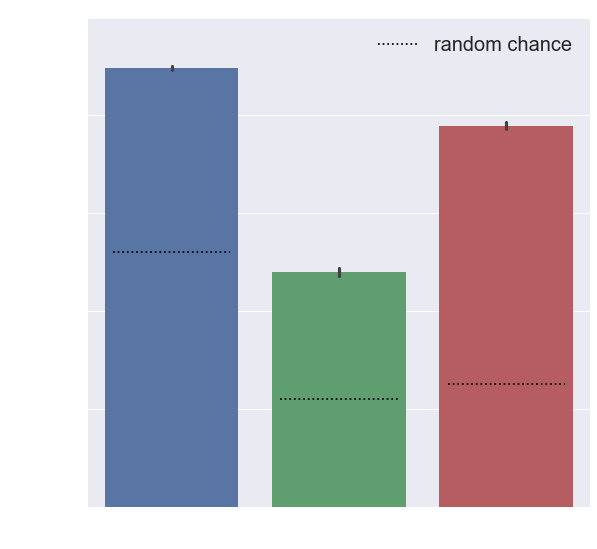

In [586]:
plt.figure(figsize=(9,9))
fontsize=30
sns.barplot(x='class',y='score',data=scores_df,ci=99)
plt.xticks(fontsize=fontsize,color='white')
plt.xlabel('')
plt.yticks(fontsize=fontsize,color='white')
plt.ylabel('model accuracy',fontsize=fontsize,color='white')
plt.ylim(0,1)
plt.hlines(y=0.52,xmin=-0.35,xmax=0.35,linestyles='dotted')
plt.hlines(y=0.22,xmin= 0.65,xmax=1.35,linestyles='dotted')
plt.hlines(y=0.25,xmin= 1.65,xmax=2.35,linestyles='dotted',label='random chance')
plt.legend(loc='best',fontsize=20)

In [523]:
y_class[2]

'med'

In [409]:
import pickle

In [413]:
filename = '/Users/shayneufeld/GitHub/pricecamp/models/rf_model.sav'
pickle.dump(forest, open(filename, 'wb'))

# accuracy of random forest

In [531]:
y_predict.shape

(935,)

In [533]:
y_test.shape

(935,)

In [541]:
np.mean(y_predict[y_test=='med'] == 'med')

0.51818181818181819

In [542]:
np.mean(y_predict[y_test=='hi'] == 'hi')

0.81981981981981977

In [543]:
np.mean(y_predict[y_test=='low'] == 'low')

0.90060851926977692